In [1]:
import os
import pandas as pd
import numpy as np
import time
from sklearn.metrics import f1_score
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from math import log

In [2]:
X_train_process1=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\X_train_glove_title.npy")
X_test_process1=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\X_test_glove_title.npy")
X_valid_process1=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\X_valid_glove_title.npy")
y_train_process=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\y_train_glove.npy")
y_test_process=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\y_test_glove.npy")
y_valid_process=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\y_valid_glove.npy")

In [3]:
train_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_train_process1),torch.LongTensor(y_train_process)),      
    batch_size=128,      
    shuffle=True,               
    num_workers=0, 
    drop_last=True
)
test_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_test_process1),torch.LongTensor(y_test_process)),      
    batch_size=128,      
    shuffle=True,               
    num_workers=0,  
    drop_last=True
)
val_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_valid_process1),torch.LongTensor(y_valid_process)),      
    batch_size=128, 
    shuffle=True,               
    num_workers=0,
    drop_last=True
)

In [4]:
def ECA(x,gamma=2,b=1):
    N,C,H,W=x.size()
    t=int(abs((log(C,2)+b)/gamma))
    k=t if t%2 else t+1
    
    avg_pool=nn.AdaptiveAvgPool2d(1).cuda()
    conv=nn.Conv1d(1,1,kernel_size=k,padding=int(k/2),bias=False).cuda()
    sigmoid=nn.Sigmoid().cuda()
    
    y=avg_pool(x)
    y=conv(y.squeeze(-1).transpose(-1,-2))
    y=y.transpose(-1,-2).unsqueeze(-1)
    y=sigmoid(y)
    return y

In [5]:
class TextRCNN(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,num_labels=5):
        super(TextRCNN,self).__init__()
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=hidden_size,
                            batch_first=True,bidirectional=True)
        self.dropout = nn.Dropout(.3)
        self.linear1 = nn.Linear(embedding_dim+hidden_size*2, 128)
        self.linear2 = nn.Linear(600, 128)
        self.linear3 = nn.Linear(128, num_labels)
        self.conv1 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=6)#通过out_channel改变文中的feature map，且out_channel∈[10,50,100,200,400,600,800,1000]
        self.conv2 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=7)
        self.conv3 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=8)
        self.conv4 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=9)

    def forward(self, x):#x: [batch,L]
        x_embed = x.cuda()
        last_hidden_state,(c,h) = self.lstm(x_embed) #last_hidden_state: [batch,L,hidden_size * num_bidirectional]
        out = torch.cat((last_hidden_state[:,:,:12],x_embed,last_hidden_state[:,:,12:]),2)#out: [batch,L,embedding_size + hidden_size * num_bidirectional]  
        out = F.tanh(self.linear1(out))
        out = out.permute(dims=[0,2,1]) #out: [batch,embedding_size + hidden_size * num_bidirectional,L]
        out_1 = self.conv1(out)
        out_1 = nn.ReLU()(out_1)
        out_1 = nn.MaxPool1d(kernel_size=495)(out_1)
        out_2 = self.conv1(out)
        out_2 = nn.ReLU()(out_2)
        out_2 = nn.MaxPool1d(kernel_size=494)(out_2)
        out_3 = self.conv1(out)
        out_3 = nn.ReLU()(out_3)
        out_3 = nn.MaxPool1d(kernel_size=493)(out_3)
        out_4 = self.conv1(out)
        out_4 = nn.ReLU()(out_4)
        out_4 = nn.MaxPool1d(kernel_size=492)(out_4)
        out_1 = out_1.unsqueeze(1).cuda()
        out_2 = out_2.unsqueeze(1).cuda()
        out_3 = out_3.unsqueeze(1).cuda()
        out_4 = out_4.unsqueeze(1).cuda()
        out = torch.cat([out_1, out_2, out_3, out_4],dim=1).cuda()
        channel_weights = F.softmax(ECA(out).squeeze().squeeze(),dim=1).unsqueeze(-1).unsqueeze(-1).expand_as(out)
        out = torch.mul(channel_weights,out)
        out = torch.sum(out, dim = 1)
        out = self.linear2(out.squeeze()) #out: [batch,num_labels]
        out = self.linear3(F.tanh(out))
        out = F.softmax(out,dim=1)
        return out

In [6]:
model = TextRCNN(5302,200,12).cuda()

In [7]:
loss_list, counter =[], []
count = 0
running_loss=0
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999),eps=1e-08,weight_decay=0)
total_train = 0
correct_train = 0
train_epoch, train_loss = [], []
train_acc, val_acc = [], []
avg_epoch, avg_train_loss, avg_val_acc = [], [], []
epoch_time=[]

model.train()
for epoch in range(128): 
    running_loss = 0
    total_train = 0
    correct_train = 0
    total_accuracy = 0
    total_val_accuracy = 0
    correct_val = 0
    total_val = 0   
    start1 = time.time()
    for i, data in enumerate(train_loader, 0):
        start = time.time()
        t_image, mask = data[0],torch.max(data[1],1)[1].long()
        t_image=t_image.cuda()
        optimizer.zero_grad()
        outputs = model(t_image) # forward
        ###########################################################################
        outputs=outputs.cuda()
        mask=mask.cuda()
        loss = criterion(outputs, mask.long()) # calculate the loss
        loss.backward() # back propagation
        optimizer.step() # update gradients
        running_loss += loss.item()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += mask.nelement()
        correct_train += predicted.eq(mask.data).sum().item()
        train_accuracy = 100 * correct_train / total_train
        total_accuracy += train_accuracy
        if i % 5 == 0:
            end = time.time()
            print('Epoch {}:[{}/{}], Current Loss: {}, Current Training Accuracy: {}, Time: {} ms'.format(epoch+1, i, len(train_loader), loss.item(), train_accuracy, end - start))      
            train_acc.append(train_accuracy)
            train_loss.append(loss.item())
            train_epoch.append(str(epoch+1) + '/' + str(i))

            for j, data1 in enumerate(val_loader, 0):
                t_image1, mask1 = data1[0],data1[1].long()
                outputs1 = model(t_image1)
                mask1_temp=torch.max(mask1.data,1)
                mask1_temp1=mask1_temp[1].cuda()
                _, predicted1 = torch.max(outputs1.data, 1)
                total_val += mask1.nelement()
                correct_val += predicted1.eq(mask1_temp1).sum().item()
                val_accuracy= 100 * correct_val / total_val
                total_val_accuracy += val_accuracy
            val_acc.append(val_accuracy)
    end1 = time.time()
    print('Epoch {}, train Loss: {:.3f} '.format(epoch+1, running_loss/len(train_loader)), "Avg Training Accuracy: {%d %%}" % (total_accuracy/len(train_loader)), "Avg Validation Accuracy: %d %%" % (total_val_accuracy/len(val_loader)), "Epoch Time: {} ms".format(end1 - start1))
    epoch_time.append(end1-start1)
    avg_epoch.append(epoch+1)
    avg_train_loss.append(running_loss/len(train_loader))
    avg_val_acc.append(total_val_accuracy/len(val_loader))
    #print(avg_epoch)
    #print(avg_train_loss)
    #print(avg_val_acc)

C:\Users\pc\.conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1:[0/16], Current Loss: 1.5982410907745361, Current Training Accuracy: 27.34375, Time: 3.2849984169006348 ms
Epoch 1:[5/16], Current Loss: 1.4833004474639893, Current Training Accuracy: 32.161458333333336, Time: 0.14099884033203125 ms
Epoch 1:[10/16], Current Loss: 1.4728724956512451, Current Training Accuracy: 36.00852272727273, Time: 0.14099955558776855 ms
Epoch 1:[15/16], Current Loss: 1.437701940536499, Current Training Accuracy: 40.8203125, Time: 0.1400010585784912 ms
Epoch 1, train Loss: 1.506  Avg Training Accuracy: {34 %} Avg Validation Accuracy: 28 % Epoch Time: 6.777997970581055 ms
Epoch 2:[0/16], Current Loss: 1.4016226530075073, Current Training Accuracy: 57.8125, Time: 0.1400008201599121 ms
Epoch 2:[5/16], Current Loss: 1.403725028038025, Current Training Accuracy: 55.989583333333336, Time: 0.14299964904785156 ms
Epoch 2:[10/16], Current Loss: 1.3426967859268188, Current Training Accuracy: 56.17897727272727, Time: 0.1399989128112793 ms
Epoch 2:[15/16], Current Loss: 

Epoch 14:[15/16], Current Loss: 0.9871799945831299, Current Training Accuracy: 87.01171875, Time: 0.1410057544708252 ms
Epoch 14, train Loss: 1.035  Avg Training Accuracy: {86 %} Avg Validation Accuracy: 61 % Epoch Time: 3.5830624103546143 ms
Epoch 15:[0/16], Current Loss: 1.0127891302108765, Current Training Accuracy: 89.0625, Time: 0.14400100708007812 ms
Epoch 15:[5/16], Current Loss: 1.027396559715271, Current Training Accuracy: 87.5, Time: 0.14099955558776855 ms
Epoch 15:[10/16], Current Loss: 0.9697962999343872, Current Training Accuracy: 87.57102272727273, Time: 0.1419999599456787 ms
Epoch 15:[15/16], Current Loss: 1.0269380807876587, Current Training Accuracy: 88.0859375, Time: 0.14099836349487305 ms
Epoch 15, train Loss: 1.023  Avg Training Accuracy: {87 %} Avg Validation Accuracy: 61 % Epoch Time: 3.613999366760254 ms
Epoch 16:[0/16], Current Loss: 0.9773218035697937, Current Training Accuracy: 92.96875, Time: 0.14500117301940918 ms
Epoch 16:[5/16], Current Loss: 1.01943290233

Epoch 28:[5/16], Current Loss: 0.9440993070602417, Current Training Accuracy: 97.65625, Time: 0.14300107955932617 ms
Epoch 28:[10/16], Current Loss: 0.9357461333274841, Current Training Accuracy: 98.1534090909091, Time: 0.14200067520141602 ms
Epoch 28:[15/16], Current Loss: 0.9426228404045105, Current Training Accuracy: 97.900390625, Time: 0.14198088645935059 ms
Epoch 28, train Loss: 0.926  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 65 % Epoch Time: 3.622002601623535 ms
Epoch 29:[0/16], Current Loss: 0.9207281470298767, Current Training Accuracy: 98.4375, Time: 0.1439981460571289 ms
Epoch 29:[5/16], Current Loss: 0.9134534597396851, Current Training Accuracy: 97.91666666666667, Time: 0.1419985294342041 ms
Epoch 29:[10/16], Current Loss: 0.921489417552948, Current Training Accuracy: 97.79829545454545, Time: 0.14200043678283691 ms
Epoch 29:[15/16], Current Loss: 0.9134783744812012, Current Training Accuracy: 97.94921875, Time: 0.1419999599456787 ms
Epoch 29, train Loss: 0.925

Epoch 41, train Loss: 0.925  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 67 % Epoch Time: 3.69891357421875 ms
Epoch 42:[0/16], Current Loss: 0.9124166965484619, Current Training Accuracy: 99.21875, Time: 0.14599871635437012 ms
Epoch 42:[5/16], Current Loss: 0.9204149842262268, Current Training Accuracy: 98.4375, Time: 0.14300084114074707 ms
Epoch 42:[10/16], Current Loss: 0.9355324506759644, Current Training Accuracy: 97.86931818181819, Time: 0.14208269119262695 ms
Epoch 42:[15/16], Current Loss: 0.9197185039520264, Current Training Accuracy: 97.998046875, Time: 0.14206981658935547 ms
Epoch 42, train Loss: 0.925  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 65 % Epoch Time: 3.688995838165283 ms
Epoch 43:[0/16], Current Loss: 0.9279659986495972, Current Training Accuracy: 97.65625, Time: 0.14307260513305664 ms
Epoch 43:[5/16], Current Loss: 0.9126693606376648, Current Training Accuracy: 97.78645833333333, Time: 0.14408326148986816 ms
Epoch 43:[10/16], Current Loss: 

Epoch 55:[10/16], Current Loss: 0.9123507738113403, Current Training Accuracy: 98.1534090909091, Time: 0.14500141143798828 ms
Epoch 55:[15/16], Current Loss: 0.9051450490951538, Current Training Accuracy: 98.2421875, Time: 0.14500069618225098 ms
Epoch 55, train Loss: 0.923  Avg Training Accuracy: {97 %} Avg Validation Accuracy: 65 % Epoch Time: 3.695997953414917 ms
Epoch 56:[0/16], Current Loss: 0.9284480810165405, Current Training Accuracy: 97.65625, Time: 0.14400124549865723 ms
Epoch 56:[5/16], Current Loss: 0.912238597869873, Current Training Accuracy: 98.69791666666667, Time: 0.14299774169921875 ms
Epoch 56:[10/16], Current Loss: 0.9424394369125366, Current Training Accuracy: 98.57954545454545, Time: 0.1419999599456787 ms
Epoch 56:[15/16], Current Loss: 0.9121952652931213, Current Training Accuracy: 98.2421875, Time: 0.14299988746643066 ms
Epoch 56, train Loss: 0.922  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 64 % Epoch Time: 3.651055097579956 ms
Epoch 57:[0/16], Curre

Epoch 69:[5/16], Current Loss: 0.9498888850212097, Current Training Accuracy: 98.046875, Time: 0.14500045776367188 ms
Epoch 69:[10/16], Current Loss: 0.9354571104049683, Current Training Accuracy: 98.4375, Time: 0.14400053024291992 ms
Epoch 69:[15/16], Current Loss: 0.9276843667030334, Current Training Accuracy: 98.291015625, Time: 0.14299988746643066 ms
Epoch 69, train Loss: 0.922  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.642998695373535 ms
Epoch 70:[0/16], Current Loss: 0.9269699454307556, Current Training Accuracy: 97.65625, Time: 0.14299798011779785 ms
Epoch 70:[5/16], Current Loss: 0.9191737174987793, Current Training Accuracy: 98.17708333333333, Time: 0.14700007438659668 ms
Epoch 70:[10/16], Current Loss: 0.9348072409629822, Current Training Accuracy: 98.22443181818181, Time: 0.14599895477294922 ms
Epoch 70:[15/16], Current Loss: 0.9120527505874634, Current Training Accuracy: 98.291015625, Time: 0.14299893379211426 ms
Epoch 70, train Loss: 0.922  

Epoch 82, train Loss: 0.922  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 64 % Epoch Time: 3.653001070022583 ms
Epoch 83:[0/16], Current Loss: 0.9204661250114441, Current Training Accuracy: 98.4375, Time: 0.14599919319152832 ms
Epoch 83:[5/16], Current Loss: 0.9205416440963745, Current Training Accuracy: 98.046875, Time: 0.14600133895874023 ms
Epoch 83:[10/16], Current Loss: 0.9277005195617676, Current Training Accuracy: 98.4375, Time: 0.145003080368042 ms
Epoch 83:[15/16], Current Loss: 0.9283743500709534, Current Training Accuracy: 98.291015625, Time: 0.14313864707946777 ms
Epoch 83, train Loss: 0.922  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.6670045852661133 ms
Epoch 84:[0/16], Current Loss: 0.9276990294456482, Current Training Accuracy: 97.65625, Time: 0.14507389068603516 ms
Epoch 84:[5/16], Current Loss: 0.9199031591415405, Current Training Accuracy: 98.56770833333333, Time: 0.14510536193847656 ms
Epoch 84:[10/16], Current Loss: 0.9127353

Epoch 96:[10/16], Current Loss: 0.9194205403327942, Current Training Accuracy: 98.7215909090909, Time: 0.14300060272216797 ms
Epoch 96:[15/16], Current Loss: 0.9432458281517029, Current Training Accuracy: 98.33984375, Time: 0.14500117301940918 ms
Epoch 96, train Loss: 0.921  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 67 % Epoch Time: 3.674483299255371 ms
Epoch 97:[0/16], Current Loss: 0.9198166131973267, Current Training Accuracy: 98.4375, Time: 0.1439988613128662 ms
Epoch 97:[5/16], Current Loss: 0.9048895239830017, Current Training Accuracy: 98.30729166666667, Time: 0.1459972858428955 ms
Epoch 97:[10/16], Current Loss: 0.9205167889595032, Current Training Accuracy: 98.57954545454545, Time: 0.1459975242614746 ms
Epoch 97:[15/16], Current Loss: 0.9432511925697327, Current Training Accuracy: 98.291015625, Time: 0.14591169357299805 ms
Epoch 97, train Loss: 0.922  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 67 % Epoch Time: 3.6710317134857178 ms
Epoch 98:[0/16], Cur

Epoch 109, train Loss: 0.922  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.6828248500823975 ms
Epoch 110:[0/16], Current Loss: 0.9205060601234436, Current Training Accuracy: 98.4375, Time: 0.14409875869750977 ms
Epoch 110:[5/16], Current Loss: 0.9119855165481567, Current Training Accuracy: 98.17708333333333, Time: 0.1450965404510498 ms
Epoch 110:[10/16], Current Loss: 0.912697970867157, Current Training Accuracy: 98.4375, Time: 0.146101713180542 ms
Epoch 110:[15/16], Current Loss: 0.935418963432312, Current Training Accuracy: 98.291015625, Time: 0.14503979682922363 ms
Epoch 110, train Loss: 0.922  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.667999505996704 ms
Epoch 111:[0/16], Current Loss: 0.9347856044769287, Current Training Accuracy: 96.875, Time: 0.1441054344177246 ms
Epoch 111:[5/16], Current Loss: 0.9048745632171631, Current Training Accuracy: 98.30729166666667, Time: 0.14910173416137695 ms
Epoch 111:[10/16], Current Loss

Epoch 123:[10/16], Current Loss: 0.9347076416015625, Current Training Accuracy: 98.29545454545455, Time: 0.14512848854064941 ms
Epoch 123:[15/16], Current Loss: 0.9126870632171631, Current Training Accuracy: 98.291015625, Time: 0.14310121536254883 ms
Epoch 123, train Loss: 0.921  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 67 % Epoch Time: 3.65671968460083 ms
Epoch 124:[0/16], Current Loss: 0.9283020496368408, Current Training Accuracy: 97.65625, Time: 0.14500641822814941 ms
Epoch 124:[5/16], Current Loss: 0.9048750996589661, Current Training Accuracy: 98.56770833333333, Time: 0.1470019817352295 ms
Epoch 124:[10/16], Current Loss: 0.9425357580184937, Current Training Accuracy: 98.08238636363636, Time: 0.1460423469543457 ms
Epoch 124:[15/16], Current Loss: 0.9119869470596313, Current Training Accuracy: 98.291015625, Time: 0.14800500869750977 ms
Epoch 124, train Loss: 0.922  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.737443447113037 ms
Epoch 125:

In [8]:
model.eval()
pred_correct_num=[]
pred_total_num=[]
pred_result_list=[]
pred_prob_list = []
label_prob_list=[]
label_list=[]
for i, data in enumerate(test_loader, 0):
    t_image, mask = data[0],torch.max(data[1],1)[1].long()
    mask=mask.cuda()
    output_test=model(t_image)
    pred_prob_list.append(output_test)
    label_prob_list.append(data[1])
    label_list.append(mask)
    output=torch.max(output_test,1)[1].long()
    pred_result_list.append(output)
    pred_correct_num.append(output.eq(mask).sum().item())
    pred_total_num.append(output_test.shape[0])
acc_test=sum(pred_correct_num)/sum(pred_total_num)
print("The accuracy of detecting news bias: {}".format(('%.4f%%'%(acc_test*100))))

The accuracy of detecting news bias: 83.8542%


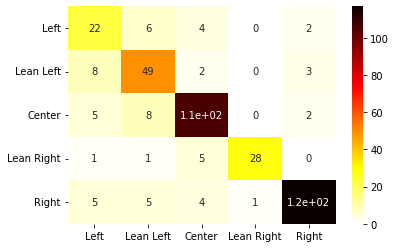

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
for i in range(len(pred_result_list)):
    if len(pred_result_list) == 1:
        pred_result = pred_result_list[0]
        label = label_list[0]
    if len(pred_result_list) == 2:
        pred_result = torch.cat((pred_result_list[0], pred_result_list[1]), -1)
        label = torch.cat((label_list[0], label_list[1]), -1)
    if len(pred_result_list) > 2:
        pred_result = torch.cat((pred_result_list[0], pred_result_list[1]), -1)
        label = torch.cat((label_list[0], label_list[1]), -1)
    for j in range(len(pred_result_list)-2):
        pred_result = torch.cat((pred_result, pred_result_list[j+2]), -1)
        label = torch.cat((label, label_list[j+2]), -1)
label = label.cpu()
pred_result = pred_result.cpu()
C=confusion_matrix(label,pred_result)
df=pd.DataFrame(C,index=["Left","Lean Left","Center","Lean Right","Right"],columns=["Left","Lean Left","Center","Lean Right","Right"])
p1=sns.heatmap(df,annot=True,cmap="hot_r")
s1 = p1.get_figure()

In [10]:
for i in range(len(pred_prob_list)):
    if len(pred_prob_list) == 1:
        pred_prob = pred_prob_list[0]
        label_prob = label_prob_list[0]
    if len(pred_prob_list) == 2:
        pred_prob = torch.cat((pred_prob_list[0], pred_prob_list[1]), -1)
        label_prob = torch.cat((label_prob_list[0], label_prob_list[1]), -1)
    if len(pred_prob_list) > 2:
        pred_prob = torch.cat((pred_prob_list[0], pred_prob_list[1]), -1)
        label_prob = torch.cat((label_prob_list[0], label_prob_list[1]), -1)
    for j in range(len(pred_prob_list)-2):
        pred_prob = torch.cat((pred_prob, pred_prob_list[j+2]), -1)
        label_prob = torch.cat((label_prob, label_prob_list[j+2]), -1)
label_prob = label_prob.cpu()
pred_prob = pred_prob.cpu()
criterion=nn.L1Loss(reduction="mean")
loss=criterion(pred_prob, label_prob)
print("MAE Value: {}".format("%.4f" % loss))

MAE Value: 0.0667


In [11]:
from sklearn.metrics import f1_score
f1_score = f1_score(pred_result,label,average="macro")
print("Macro-F1 Score: {}".format("%.4f" % f1_score))

Macro-F1 Score: 0.8000
